# Лабораторная работа №4

### Томография квантовых состояний в непрерывных переменных

Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.linalg import expm
import seaborn as sns

from scipy.special import hermite
from scipy.special import factorial

Определяем оператор уничтожения.

In [2]:
def get_a(n_max):
    a = np.zeros((n_max + 1, n_max + 1), dtype=complex)
    for i in range(0, n_max, 1):
        a[i, i + 1] = np.sqrt(i + 1)
    return a

Определяем оператор сжатия.

In [3]:
def get_S(ksi, n_max):
    a = get_a(n_max)
    S = expm(0.5 * (ksi.conjugate() * (a @ a) - ksi * (a.T.conjugate() @ a.T.conjugate())))
    return S

Генерируем требуемое квантовое состояние.

In [4]:
def get_pure_state(ksi, n_max):
    S = get_S(ksi, n_max)
    psi = np.zeros(n_max + 1, dtype=complex)
    psi[1] = 1.0
    psi = np.dot(S, psi)
    return psi

Определяем ошибку, связанную с ограничением максимального числа фотонов.

In [5]:
def get_error_modeling(ksi, n_max):
    n_large = 100
    psi = get_pure_state(ksi, n_large)
    norm = np.sum(np.abs(psi[0:n_max + 1]) ** 2)
    error = 1 - norm
    return error

In [6]:
eps = 1e-6
ksi = 0.2 + 1j * 0.8

Определяем необходимую размерность гильбертового пространства.

In [7]:
n_max = 1
error = get_error_modeling(ksi, n_max)
while error > eps:
    n_max += 1
    error = get_error_modeling(ksi, n_max)
print('n_max = ', n_max, ', error = ', error)

n_max =  39 , error =  6.674486749957964e-07


Генерируем квантовое состояние.

In [8]:
psi = get_pure_state(ksi, n_max)

Определяем функции, необходимые для расчёта квадратурных распределений.

In [9]:
def hermit_cheb(x, n):
    return (1 / np.sqrt((2 ** n) * factorial(n) * np.sqrt(np.pi))) * hermite(n)(x) * np.exp(-(x ** 2) / 2)

In [10]:
def get_phi_theta(x, theta, n):
    return hermit_cheb(x, n) * np.exp(1j * n * theta)

In [11]:
def get_psi_theta(x, theta, psi):
    return np.sum(np.array([psi[n] * get_phi_theta(x, theta, n) for n in range(0, n_max + 1, 1)]), axis=0)

In [12]:
def get_density_probability(x, theta, psi):
    prob = np.abs(get_psi_theta(x, theta, psi)) ** 2
    return prob

In [13]:
list_theta = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

In [14]:
x_span = np.linspace(-10, 10, 1000)
dens_prob_list = [np.array([get_density_probability(x, theta, psi) for x in x_span]) for theta in list_theta]

Сторим квадратурные распределения.

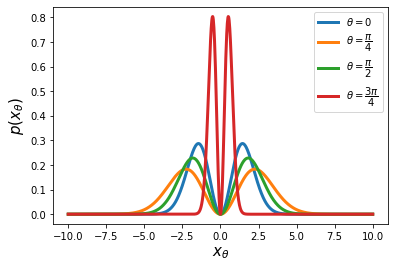

In [15]:
fig, ax = plt.subplots()
plt.plot(x_span, dens_prob_list[0], lw=3, alpha=1, label=r'$\theta = 0$')
plt.plot(x_span, dens_prob_list[1], lw=3, alpha=1, label=r'$\theta = \dfrac{\pi}{4}$')
plt.plot(x_span, dens_prob_list[2], lw=3, alpha=1, label=r'$\theta = \dfrac{\pi}{2}$')
plt.plot(x_span, dens_prob_list[3], lw=3, alpha=1, label=r'$\theta = \dfrac{3 \pi}{4}$')
ax.minorticks_off()
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
ax.legend(loc='upper right')
plt.show()

In [16]:
from scipy.integrate import quad

Находим функцию распределения вероятностей.

In [17]:
def get_func_distr(x, theta, psi):
    x_span = np.linspace(-10, x, 1000)
    prob = np.trapz(get_density_probability(x_span, theta, psi), x_span)
    return prob

In [18]:
x_span = np.linspace(-10, 10, 1000)
func_distr_0 = []
func_distr_1 = []
func_distr_2 = []
func_distr_3 = []
for x in x_span:
    func_distr_0.append(get_func_distr(x, list_theta[0], psi))
    func_distr_1.append(get_func_distr(x, list_theta[1], psi))
    func_distr_2.append(get_func_distr(x, list_theta[2], psi))
    func_distr_3.append(get_func_distr(x, list_theta[3], psi))
func_distr_0 = np.array(func_distr_0)
func_distr_1 = np.array(func_distr_1)
func_distr_2 = np.array(func_distr_2)
func_distr_3 = np.array(func_distr_3)

Сторим функции распределения вероятностей.

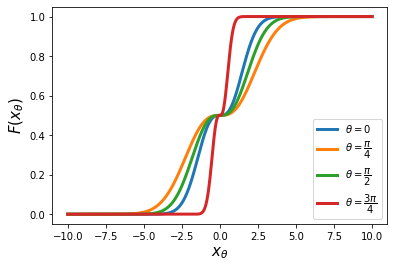

In [19]:
fig, ax = plt.subplots()
plt.plot(x_span, func_distr_0, lw=3, alpha=1, label=r'$\theta = 0$')
plt.plot(x_span, func_distr_1, lw=3, alpha=1, label=r'$\theta = \dfrac{\pi}{4}$')
plt.plot(x_span, func_distr_2, lw=3, alpha=1, label=r'$\theta = \dfrac{\pi}{2}$')
plt.plot(x_span, func_distr_3, lw=3, alpha=1, label=r'$\theta = \dfrac{3 \pi}{4}$')
ax.minorticks_off()
ax.legend(loc='lower right')
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$F(x_{\theta})$', fontsize=15)
plt.show()

In [20]:
from scipy.interpolate import interp1d

In [21]:
x_span = np.array([-11] + list(x_span) + [11])
func_distr_0 = np.array([0] + list(func_distr_0) + [1])
func_distr_1 = np.array([0] + list(func_distr_1) + [1])
func_distr_2 = np.array([0] + list(func_distr_2) + [1])
func_distr_3 = np.array([0] + list(func_distr_3) + [1])

Определяем обратные функции для сэмплирования результатов.

In [22]:
inverse_func_0 = interp1d(func_distr_0, x_span)
inverse_func_1 = interp1d(func_distr_1, x_span)
inverse_func_2 = interp1d(func_distr_2, x_span)
inverse_func_3 = interp1d(func_distr_3, x_span)

Сэмплируем экспериментальные данные.

In [23]:
k = 20000
sample_x_theta_0 = []
sample_x_theta_1 = []
sample_x_theta_2 = []
sample_x_theta_3 = []
for i in range(k):
    F = np.random.rand()
    sample_x_theta_0.append(inverse_func_0(F))
    F = np.random.rand()
    sample_x_theta_1.append(inverse_func_1(F))
    F = np.random.rand()
    sample_x_theta_2.append(inverse_func_2(F))
    F = np.random.rand()
    sample_x_theta_3.append(inverse_func_3(F))
sample_x_theta_0 = np.array(sample_x_theta_0)
sample_x_theta_1 = np.array(sample_x_theta_1)
sample_x_theta_2 = np.array(sample_x_theta_2)
sample_x_theta_3 = np.array(sample_x_theta_3)

In [24]:
x_span = x_span[1:-1]

In [25]:
def plot_hist_samples(sample_x_theta, dens_prob_list, label, bins=50, color='blue'):
    fig, ax = plt.subplots()
    plt.hist(sample_x_theta, bins=50, color=color, alpha=0.3, density=True, label=label)
    plt.plot(x_span, dens_prob_list, color=color, lw=3, alpha=1)
    plt.xlabel(r'$x_{\theta}$', fontsize=15)
    plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
    ax.legend(loc='lower right')
    plt.show()

Строим гистограммы экспериментальных данных.

In [26]:
plot_hist_samples(sample_x_theta_0, dens_prob_list[0], r'$\theta = 0$', color='blue')

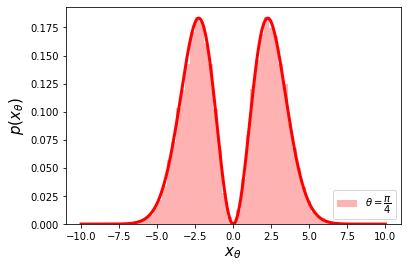

In [27]:
plot_hist_samples(sample_x_theta_1, dens_prob_list[1], r'$\theta = \dfrac{\pi}{4}$', color='red')

In [28]:
plot_hist_samples(sample_x_theta_2, dens_prob_list[2], r'$\theta = \dfrac{\pi}{2}$', color='green')

In [29]:
plot_hist_samples(sample_x_theta_3, dens_prob_list[3], r'$\theta = \dfrac{3 \pi}{4}$', color='gray')

In [30]:
sample_x_theta = np.array(list(sample_x_theta_0) + list(sample_x_theta_1) + list(sample_x_theta_2) + list(sample_x_theta_3)).reshape((4, k))
sample_theta = np.array([list_theta[0]] * k + [list_theta[1]] * k + [list_theta[2]] * k + [list_theta[3]] * k).reshape((4, k))
n = len(sample_x_theta.reshape(-1))

In [31]:
def gen_stoch_psi(n_max):
    psi = np.random.randn(n_max + 1) + 1j * np.random.randn(n_max + 1)
    psi = psi / np.sqrt(np.sum(np.abs(psi) ** 2))
    return psi

In [32]:
def get_frobenius_norm(a):
    return np.sum(np.abs(a) ** 2)

In [33]:
import copy

In [34]:
def p_fast(phi_theta, psi):
    return abs(np.tensordot(psi, phi_theta, axes=1))**2

In [35]:
phi_theta = np.array([get_phi_theta(sample_x_theta, sample_theta, n) for n in range(n_max + 1)])
phi_matrix = np.array([[np.conj(get_phi_theta(sample_x_theta, sample_theta, k)) * get_phi_theta(sample_x_theta, sample_theta, l) for l in range(n_max + 1)] for k in range(n_max + 1)])
                                      
def get_R(psi):
    ps = p_fast(phi_theta, psi)
    return np.tensordot(phi_matrix, 1 / ps, axes=2)

Проводим томографию с помощью ММП.

In [36]:
eps_error = 1e-8
mu = 0.5
psi_rec = gen_stoch_psi(n_max)
psi_prev = np.zeros_like(psi_rec)
iteration = 1
while(np.sqrt(get_frobenius_norm(psi_rec - psi_prev)) > eps_error):
    print('Iteration: ', iteration, 'Error: ', np.sqrt(get_frobenius_norm(psi_rec - psi_prev)))
    psi_prev = psi_rec
    psi_rec = (1 - mu) * np.dot(get_R(psi_prev), psi_prev) / np.prod(sample_x_theta.shape) + mu * psi_prev
    iteration += 1

Iteration:  1 Error:  1.0
Iteration:  2 Error:  0.6206418476186878
Iteration:  3 Error:  0.2979736654193396
Iteration:  4 Error:  0.18297873060453201
Iteration:  5 Error:  0.16544103187810474
Iteration:  6 Error:  0.10720726359111504
Iteration:  7 Error:  0.0790414526620816
Iteration:  8 Error:  0.1568000003994528
Iteration:  9 Error:  0.09067840781376608
Iteration:  10 Error:  0.06586280091282042
Iteration:  11 Error:  0.051315547442284136
Iteration:  12 Error:  0.04375908271196454
Iteration:  13 Error:  0.05369688039612298
Iteration:  14 Error:  0.042885496825885036
Iteration:  15 Error:  0.03579181772421901
Iteration:  16 Error:  0.03675238366223647
Iteration:  17 Error:  0.038465475864680125
Iteration:  18 Error:  0.17523140648355273
Iteration:  19 Error:  0.06486434553724117
Iteration:  20 Error:  0.043982472817754234
Iteration:  21 Error:  0.03282756978309918
Iteration:  22 Error:  0.026114172526904948
Iteration:  23 Error:  0.02205703101490114
Iteration:  24 Error:  0.0197663836

In [37]:
fock_n = np.linspace(0, n_max, n_max + 1)

Смотрим на распределение по числу фотонов.

In [38]:
plt.bar(fock_n - 0.1, np.abs(psi_rec) ** 2, color='red', alpha=0.5, width=0.5, label='Reconstruction')
plt.bar(fock_n + 0.1, np.abs(psi) ** 2, color='green', alpha=0.5, width=0.5, label='Real state')
plt.xlabel('n')
plt.ylabel('p(n)')
plt.xlim(0, 23)
plt.legend()
plt.show()

Вычисляем фиделити.

In [39]:
fidelity = np.abs(psi @ np.conj(psi_rec)) ** 2
print('Fidelity =', fidelity)

Fidelity = 0.9996850487486167


In [40]:
def plot_hist_samples_with_reconstruction(sample_x_theta, dens_prob_list, dens_prob_list_rec, label, bins=50, color='blue'):
    fig, ax = plt.subplots()
    plt.hist(sample_x_theta, bins=50, color=color, alpha=0.3, density=True, label=label)
    plt.plot(x_span, dens_prob_list, color=color, lw=3, alpha=0.5, label='Ideal')
    plt.plot(x_span, dens_prob_list_rec, '--', color=color, lw=3, alpha=1, label='Reconstruction')
    plt.xlabel(r'$x_{\theta}$', fontsize=15)
    plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
    ax.legend(loc='lower right')
    plt.show()

Строим гистограммы для сравнения экспериментальных данных и реконструированного состояния.

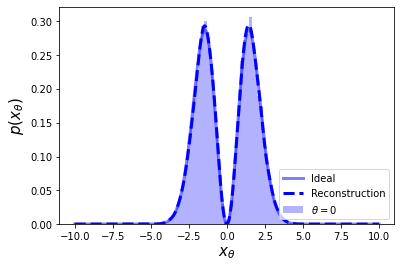

In [41]:
plot_hist_samples_with_reconstruction(sample_x_theta[0], dens_prob_list[0], get_density_probability(x_span, list_theta[0], psi_rec), r'$\theta = 0$', color='blue')

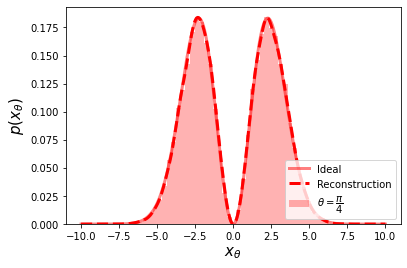

In [42]:
plot_hist_samples_with_reconstruction(sample_x_theta[1], dens_prob_list[1], get_density_probability(x_span, list_theta[1], psi_rec), r'$\theta = \dfrac{\pi}{4}$', color='red')

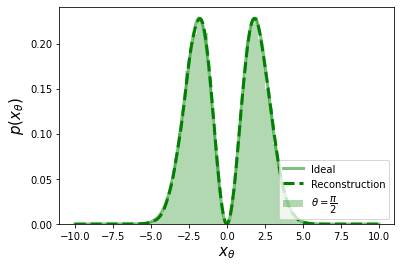

In [43]:
plot_hist_samples_with_reconstruction(sample_x_theta[2], dens_prob_list[2], get_density_probability(x_span, list_theta[2], psi_rec), r'$\theta = \dfrac{\pi}{2}$', color='green')

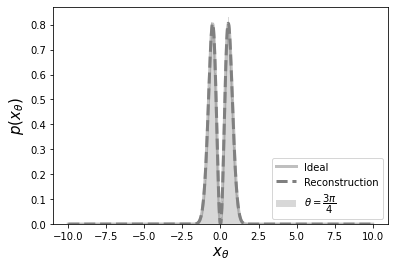

In [44]:
plot_hist_samples_with_reconstruction(sample_x_theta[3], dens_prob_list[3], get_density_probability(x_span, list_theta[3], psi_rec), r'$\theta = \dfrac{3 \pi}{4}$', color='gray')

Вычисляем хи-квадрат.

In [45]:
M = 200
chi2_value = 0
for i in range(len(list_theta)):
    bins = np.quantile(sample_x_theta[i], np.linspace(0, 1, M + 1))
    O, G = np.histogram(sample_x_theta[i], bins=bins)
    E = np.zeros_like(O, dtype=float)
    for j in range(len(G) - 1):
        E[j] = k * quad(lambda x: get_density_probability(x, list_theta[i], psi_rec), G[j], G[j + 1])[0]
        chi2_value += (O[j] - E[j]) ** 2 / E[j]

In [46]:
chi2_value

736.8668382848206

In [47]:
from scipy.stats import chi2

Вычисляем p-value.

In [48]:
nu = 4 * M - len(list_theta) - (2 * n_max + 1)
p_value = 1 - chi2.cdf(chi2_value, nu)
print('p-value = ' + str(p_value))

p-value = 0.2954858682337512


In [49]:
nu

717